In [ ]:
!pip install scikit-learn==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd
import numpy as np
import os
import json
#import mysql.connector
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Projects/AuctionHouse

Mounted at /content/drive
/content/drive/MyDrive/Projects/AuctionHouse


## Retrieve most recent data

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password",
  database="auction_db"
)

In [ ]:
with open("data/sql/get_data.sql", "r") as f:
    sql = f.read()

In [ ]:
cursor = mydb.cursor()

cursor.execute(sql)

auctions = cursor.fetchall()

headers = [column[0] for column in cursor.description]

cursor.close()

In [ ]:
with open('auction_data.csv', 'w', newline='') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(headers)
    for row in auctions:
        csv_out.writerow(row)

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password",
  database="auction_db"
)

cursor = mydb.cursor()

cursor.execute(sql)

auctions = cursor.fetchall()

headers = [column[0] for column in cursor.description]

cursor.close()

with open('auction_data.csv', 'w', newline='') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(headers)
    for row in auctions:
        csv_out.writerow(row)

## Read data from CSV

In [ ]:
df = pd.read_csv('auction_data.csv')
df.head(5)

,auction_id,bid_in_gold,buyout_in_gold,unit_price,quantity,time_left,item_id,item_name,quality,item_class,...,purchase_price_gold,required_level,item_level,sell_price_gold,first_appearance_timestamp,first_appearance_year,first_appearance_month,first_appearance_day,first_appearance_hour,hours_on_sale
0,962303457,24.4708,27.1898,27.1898,1,SHORT,13009,Cow King's Hide,Rare,Armor,...,7,46,51,1,2024-01-02 00:00:00,2024,1,2,0,1
1,962303587,75.5135,83.9039,83.9039,1,SHORT,24684,Archmage Bracelets,Uncommon,Armor,...,7,69,117,1,2024-01-02 00:00:00,2024,1,2,0,1
2,962303596,260.2195,289.1328,289.1328,1,SHORT,24695,Bonechewer Chestpiece,Uncommon,Armor,...,13,57,81,2,2024-01-02 00:00:00,2024,1,2,0,1
3,962303611,28.1145,31.2383,31.2383,1,SHORT,7535,Cabalist Belt,Uncommon,Armor,...,2,41,46,0,2024-01-02 00:00:00,2024,1,2,0,1
4,962303620,117.5188,130.5764,130.5764,1,SHORT,36069,Daggercap Jerkin,Uncommon,Armor,...,21,67,130,4,2024-01-02 00:00:00,2024,1,2,0,1


In [ ]:
df.columns

Index(['auction_id', 'bid_in_gold', 'buyout_in_gold', 'unit_price', 'quantity',
       'time_left', 'item_id', 'item_name', 'quality', 'item_class',
       'item_subclass', 'is_stackable', 'purchase_price_gold',
       'required_level', 'item_level', 'sell_price_gold',
       'first_appearance_timestamp', 'first_appearance_year',
       'first_appearance_month', 'first_appearance_day',
       'first_appearance_hour', 'hours_on_sale'],
      dtype='object')

In [ ]:
df.shape

(14252509, 22)

In [ ]:
df['time_left'].value_counts()

time_left
LONG         7538093
VERY_LONG    6698976
SHORT           8907
MEDIUM          6533
Name: count, dtype: int64

# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252509 entries, 0 to 14252508
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   auction_id                  int64  
 1   bid_in_gold                 float64
 2   buyout_in_gold              float64
 3   unit_price                  float64
 4   quantity                    int64  
 5   time_left                   object 
 6   item_id                     int64  
 7   item_name                   object 
 8   quality                     object 
 9   item_class                  object 
 10  item_subclass               object 
 11  is_stackable                int64  
 12  purchase_price_gold         int64  
 13  required_level              int64  
 14  item_level                  int64  
 15  sell_price_gold             int64  
 16  first_appearance_timestamp  object 
 17  first_appearance_year       int64  
 18  first_appearance_month      int64  
 19  first_appearance_da

In [ ]:
# where 'hours_on_sale' is < 12, the auction was sold set to 1, else 0
df['sold'] = np.where(df['hours_on_sale'] < 12, 1, 0)

In [ ]:
columns = ['bid_in_gold', 'buyout_in_gold', 'quantity', 'hours_on_sale']
df[columns].describe()

## Percentage of items sold

In [ ]:
df_count = df['sold'].value_counts(normalize=True)
df_count = df_count.mul(100)
df_count = df_count.rename('percent').reset_index()
df_count['sold'] = df_count['index']

g = sns.catplot(x='sold', y='percent', kind='bar', data=df_count)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 3
    g.ax.text(txt_x,txt_y,txt)

## Most popular Item

In [ ]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemName']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='ItemName', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

KeyError: 'Sold'

## Most popular Item Class

In [ ]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemClass']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(100))

plot = sns.barplot(x='ItemClass', y='Counts', data=count_items[:5])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Most popular Item Subclass

In [ ]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemSubClass']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='ItemSubClass', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Most sold quality tipe

In [ ]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['Quality']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='Quality', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Are most sold items equippable?

In [ ]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['IsEquippable']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)[:10]

print(count_items.head())

plot = sns.barplot(x='IsEquippable', y='Counts', data=count_items)

## Best week day to sell

In [ ]:
import datetime

df['WeekDay'] = df.apply(lambda row: datetime.datetime(row['FirstTimeSeenYear'], row['FirstTimeSeenMonth'], row['FirstTimeSeenDay']).weekday(), axis=1)

count_items = df.groupby(['WeekDay']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)[:10]

print(count_items.head(10))

plot = sns.barplot(x='WeekDay', y='Counts', data=count_items)

# Data Preparation

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

feature_names = []

def transform_time_left(df):
  df['time_left'] = np.where(df['time_left'] == 'SHORT', 2, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'MEDIUM', 12, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'LONG', 24, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'VERY_LONG', 48, df['time_left'])

  return df


def compute_median_competitor_price(df):
    group = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day', 'first_appearance_hour'])
    df['median_buyout_price'] = group['buyout_in_gold'].transform('median')
    df['median_bid_price'] = group['bid_in_gold'].transform('median')
    df['median_unit_price'] = group['unit_price'].transform('median')

    df['rank_buyout_price'] = group['buyout_in_gold'].rank(ascending=True)
    df['rank_bid_price'] = group['bid_in_gold'].rank(ascending=True)
    df['rank_unit_price'] = group['unit_price'].rank(ascending=True)

    return df


def compute_avg_competitor_price(df):
    df['avg_competitor_price'] = df.groupby(['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day', 'first_appearance_hour'])['unit_price'].transform('mean')
    df['std_competitor_price'] = df.groupby(['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day', 'first_appearance_hour'])['unit_price'].transform('std')

    df['avg_competitor_price'].fillna(0, inplace=True)
    df['std_competitor_price'].fillna(0, inplace=True)

    return df


def compute_competitor_count(df):
    df['competitor_count'] = df.groupby(['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day', 'first_appearance_hour'])['unit_price'].transform('count')
    df['competitor_count'].fillna(0, inplace=True)

    return df


def compute_minimum_competitor_price(df):
    minimum_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].quantile(0.15).reset_index(name='lowest_competitor_price')

    df_merged = pd.merge(df, minimum_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['lowest_competitor_price'] = df_merged['lowest_competitor_price'].fillna(0)

    return df_merged


def compute_top_competitor_price(df):
    top_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].quantile(0.80).reset_index(name='top_competitor_price')

    df_merged = pd.merge(df, top_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['top_competitor_price'] = df_merged['top_competitor_price'].fillna(0)

    return df_merged


def compute_relative_differences(df):
  df['relative_price_difference'] = np.log(df['unit_price']+ 1e-6) - np.log(df['median_unit_price'] + 1e-6)
  df['relative_price_difference'] = df['relative_price_difference'].fillna(0)

  df['relative_avg_price_difference'] = np.log(df['unit_price']+ 1e-6) - np.log(df['avg_competitor_price'] + 1e-6)
  df['relative_avg_price_difference'] = df['relative_avg_price_difference'].fillna(0)

  df['relative_buyout_difference'] = np.log(df['buyout_in_gold']+ 1e-6) - np.log(df['median_buyout_price'] + 1e-6)
  df['relative_buyout_difference'] = df['relative_buyout_difference'].fillna(0)

  df['relative_bid_difference'] = np.log(df['bid_in_gold']+ 1e-6) - np.log(df['median_bid_price'] + 1e-6)
  df['relative_bid_difference'] = df['relative_bid_difference'].fillna(0)

  df['relative_price_to_lowest_competitor'] = np.log(df['unit_price']+ 1e-6) - np.log(df['lowest_competitor_price'] + 1e-6)
  df['relative_price_to_lowest_competitor'] = df['relative_price_to_lowest_competitor'].fillna(0)

  df['relative_price_to_top_competitor'] = np.log(df['unit_price']+ 1e-6) - np.log(df['top_competitor_price'] + 1e-6)
  df['relative_price_to_top_competitor'] = df['relative_price_to_top_competitor'].fillna(0)

  return df


def add_features(df):
  df = transform_time_left(df)
  df = compute_median_competitor_price(df)
  df = compute_avg_competitor_price(df)
  df = compute_competitor_count(df)
  df = compute_minimum_competitor_price(df)
  df = compute_top_competitor_price(df)
  df = compute_relative_differences(df)

  return df


def transform_data(df):
  numerical_columns = [
    'quantity',
    'unit_price',
    'bid_in_gold',
    'buyout_in_gold',
    'time_left',
    'median_buyout_price',
    'median_bid_price',
    'median_unit_price',
    'lowest_competitor_price',
    'avg_competitor_price',
    'std_competitor_price',
    'top_competitor_price',
    'competitor_count',
    'rank_buyout_price',
    'rank_bid_price',
    'rank_unit_price',
    'relative_price_difference',
    'relative_avg_price_difference',
    'relative_buyout_difference',
    'relative_bid_difference',
    'relative_price_to_lowest_competitor',
    'relative_price_to_top_competitor',
    'purchase_price_gold',
    'sell_price_gold',
    'required_level',
    'item_level',
    'item_id',
  ]

  categorical_columns_ordinal = [
    'quality',
    'item_class',
    'item_subclass'
  ]

  categorical_columns_onehot = [
    'is_stackable'
  ]

  X = df[numerical_columns + categorical_columns_ordinal + categorical_columns_onehot]
  y = df['hours_on_sale']

  num_transformer = StandardScaler()
  ordinal_transformer = OrdinalEncoder()
  onehot_transformer = OneHotEncoder(sparse_output=False)

  column_transformer = make_column_transformer(
      #(num_transformer, numerical_columns),
      (ordinal_transformer, categorical_columns_ordinal),
      (onehot_transformer, categorical_columns_onehot),

      remainder='passthrough'
  )

  X = column_transformer.fit_transform(X)
  y = np.array(y)

  return X, y

In [ ]:
def randomly_delete_data(df, percentage):
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100")

    # Calculate the number of rows to delete
    num_rows_to_delete = int(len(df) * (percentage / 100))

    # Randomly select rows to delete
    rows_to_delete = np.random.choice(df.index, size=num_rows_to_delete, replace=False)

    # Delete selected rows from the DataFrame
    df_after_deletion = df.drop(rows_to_delete)

    return df_after_deletion

df = randomly_delete_data(df, 50)
df.shape

(341186, 39)

In [ ]:
df = add_features(df)
df.head()

,auction_id,bid_in_gold,buyout_in_gold,unit_price,quantity,time_left,item_id,item_name,quality,item_class,...,std_competitor_price,competitor_count,lowest_competitor_price,top_competitor_price,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor
0,962303457,24.4708,27.1898,27.1898,1,2,13009,Cow King's Hide,Rare,Armor,...,0.000424,2,27.189045,27.18944,0.000011,0.000011,0.000011,-0.027389,0.000028,0.000013
1,962303587,75.5135,83.9039,83.9039,1,2,24684,Archmage Bracelets,Uncommon,Armor,...,0.000000,1,96.985505,153.67246,0.000000,0.000000,0.000000,0.000000,-0.144889,-0.605151
2,962303596,260.2195,289.1328,289.1328,1,2,24695,Bonechewer Chestpiece,Uncommon,Armor,...,69.994167,2,59.907460,249.53812,0.187751,0.187751,0.187751,0.165949,1.574085,0.147274
3,962303611,28.1145,31.2383,31.2383,1,2,7535,Cabalist Belt,Uncommon,Armor,...,4.972728,2,25.620870,30.31206,0.119417,0.119417,0.119417,0.072048,0.198238,0.030099
4,962303620,117.5188,130.5764,130.5764,1,2,36069,Daggercap Jerkin,Uncommon,Armor,...,46.232766,3,74.522150,130.57640,0.000000,0.228685,0.000000,0.000000,0.560862,0.000000


In [ ]:
df.columns

Index(['auction_id', 'bid_in_gold', 'buyout_in_gold', 'unit_price', 'quantity',
       'time_left', 'item_id', 'item_name', 'quality', 'item_class',
       'item_subclass', 'is_stackable', 'purchase_price_gold',
       'required_level', 'item_level', 'sell_price_gold',
       'first_appearance_timestamp', 'first_appearance_year',
       'first_appearance_month', 'first_appearance_day',
       'first_appearance_hour', 'hours_on_sale', 'median_buyout_price',
       'median_bid_price', 'median_unit_price', 'rank_buyout_price',
       'rank_bid_price', 'rank_unit_price', 'avg_competitor_price',
       'std_competitor_price', 'competitor_count', 'lowest_competitor_price',
       'top_competitor_price', 'relative_price_difference',
       'relative_avg_price_difference', 'relative_buyout_difference',
       'relative_bid_difference', 'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor'],
      dtype='object')

In [ ]:
print(f'Dataframe shape before duplicates {df.shape}')

df = df.drop_duplicates(subset=['first_appearance_year', 'first_appearance_month', 'first_appearance_day', 'first_appearance_hour', 'buyout_in_gold', 'item_id'])

print(f'Dataframe shape after duplicates {df.shape}')

df.head()

Dataframe shape before duplicates (14252509, 39)
Dataframe shape after duplicates (5462483, 39)


,auction_id,bid_in_gold,buyout_in_gold,unit_price,quantity,time_left,item_id,item_name,quality,item_class,...,std_competitor_price,competitor_count,lowest_competitor_price,top_competitor_price,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor
0,962303457,24.4708,27.1898,27.1898,1,2,13009,Cow King's Hide,Rare,Armor,...,0.000424,2,27.189045,27.18944,0.000011,0.000011,0.000011,-0.027389,0.000028,0.000013
1,962303587,75.5135,83.9039,83.9039,1,2,24684,Archmage Bracelets,Uncommon,Armor,...,0.000000,1,96.985505,153.67246,0.000000,0.000000,0.000000,0.000000,-0.144889,-0.605151
2,962303596,260.2195,289.1328,289.1328,1,2,24695,Bonechewer Chestpiece,Uncommon,Armor,...,69.994167,2,59.907460,249.53812,0.187751,0.187751,0.187751,0.165949,1.574085,0.147274
3,962303611,28.1145,31.2383,31.2383,1,2,7535,Cabalist Belt,Uncommon,Armor,...,4.972728,2,25.620870,30.31206,0.119417,0.119417,0.119417,0.072048,0.198238,0.030099
4,962303620,117.5188,130.5764,130.5764,1,2,36069,Daggercap Jerkin,Uncommon,Armor,...,46.232766,3,74.522150,130.57640,0.000000,0.228685,0.000000,0.000000,0.560862,0.000000


In [ ]:
df = df[(df['time_left'] != 2)]

print(f'Dataframe shape after delete SHORT time_left {df.shape}')

Dataframe shape after delete SHORT time_left (5458975, 39)


In [ ]:
bins = pd.cut(df['hours_on_sale'], bins=5)
bin_freq = bins.value_counts()

target_freq = bin_freq.min()

undersampled_bins = []
for bin, freq in bin_freq.items():
  if freq > target_freq:
    samples_to_keep = df[bins == bin].sample(n=target_freq)
    undersampled_bins.append(samples_to_keep)
  else:
    undersampled_bins.append(df[bins == bin])

df_undersampled = pd.concat(undersampled_bins)

bins = pd.cut(df_undersampled['hours_on_sale'], bins=5)
bins.value_counts()

hours_on_sale
(0.949, 11.2]    2091
(11.2, 21.4]     2091
(21.4, 31.6]     2091
(31.6, 41.8]     2091
(41.8, 52.0]     2091
Name: count, dtype: int64

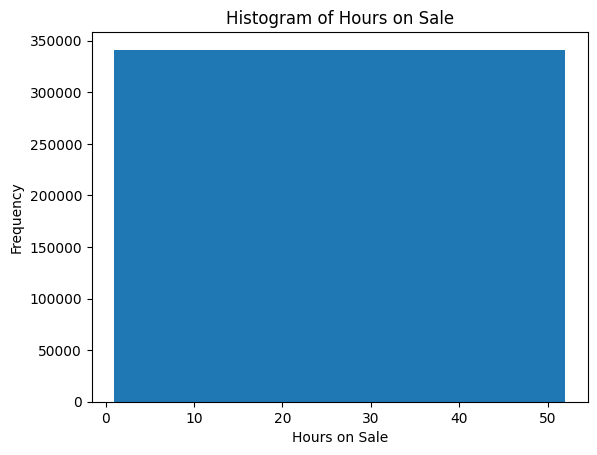

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['hours_on_sale'], bins=1)
plt.xlabel('Hours on Sale')
plt.ylabel('Frequency')
plt.title('Histogram of Hours on Sale')
plt.show()

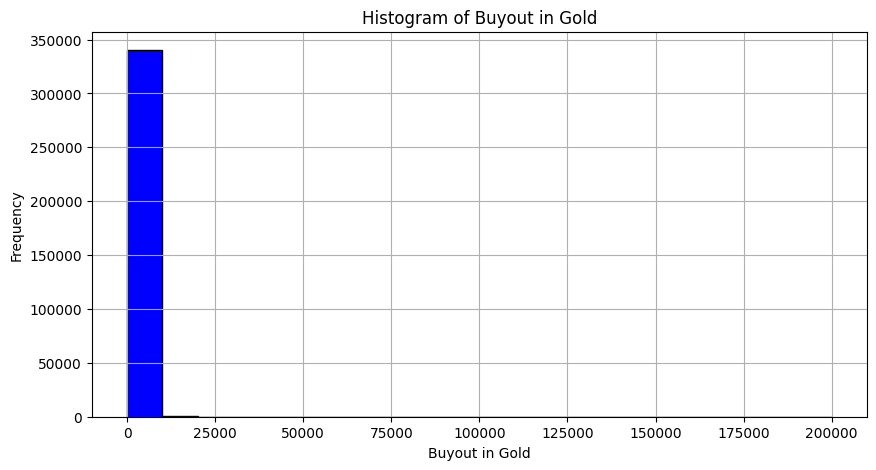

Range: 200000.0
Mean: 421.9789190488472
Median: 30.6301
Standard Deviation: 2639.0511962812766


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df['buyout_in_gold'], bins=20, color='b', edgecolor='black')
plt.title('Histogram of Buyout in Gold')
plt.xlabel('Buyout in Gold')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

range_value = df['buyout_in_gold'].max() - df['buyout_in_gold'].min()
mean_value = df['buyout_in_gold'].mean()
median_value = df['buyout_in_gold'].median()
std_dev_value = df['buyout_in_gold'].std()

# Printing statistics
print(f"Range: {range_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev_value}")

In [ ]:
from sklearn.model_selection import train_test_split

df = df.sort_values(by='first_appearance_timestamp')
df_train, df_test = train_test_split(df, random_state=0, test_size=0.1, shuffle=False)

print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (307067, 39)
df_test shape: (34119, 39)


In [ ]:
del df

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


def transform_time_left(df):
  df['time_left'] = np.where(df['time_left'] == 'SHORT', 2, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'MEDIUM', 12, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'LONG', 24, df['time_left'])
  df['time_left'] = np.where(df['time_left'] == 'VERY_LONG', 48, df['time_left'])

  return df


def compute_median_competitor_price(df):
    df['median_buyout_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['buyout_in_gold'].transform('median')
    df['median_bid_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['bid_in_gold'].transform('median')
    df['median_unit_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].transform('median')

    df['rank_buyout_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['buyout_in_gold'].rank(ascending=True)
    df['rank_bid_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['bid_in_gold'].rank(ascending=True)
    df['rank_unit_price'] = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].rank(ascending=True)

    return df


def compute_avg_competitor_price(df):
    avg_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].mean().reset_index(name='avg_competitor_price')
    std_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].std().reset_index(name='std_competitor_price')

    df_merged = pd.merge(df, avg_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['avg_competitor_price'] = df_merged['avg_competitor_price'].fillna(0)

    df_merged = pd.merge(df_merged, std_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['std_competitor_price'] = df_merged['std_competitor_price'].fillna(0)

    return df_merged


def compute_competitor_count(df):
    competitor_count = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].count().reset_index(name='competitor_count')

    df_merged = pd.merge(df, competitor_count, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['competitor_count'] = df_merged['competitor_count'].fillna(0)

    return df_merged


def compute_minimum_competitor_price(df):
    minimum_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].quantile(0.15).reset_index(name='lowest_competitor_price')

    df_merged = pd.merge(df, minimum_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['lowest_competitor_price'] = df_merged['lowest_competitor_price'].fillna(0)

    return df_merged


def compute_top_competitor_price(df):
    top_competitor_price = df.groupby(by=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'])['unit_price'].quantile(0.80).reset_index(name='top_competitor_price')

    df_merged = pd.merge(df, top_competitor_price, on=['item_id', 'first_appearance_year', 'first_appearance_month', 'first_appearance_day'], how='left')
    df_merged['top_competitor_price'] = df_merged['top_competitor_price'].fillna(0)

    return df_merged


def compute_relative_differences(df):
  df['relative_price_difference'] = (df['unit_price'] - df['median_unit_price']) / (df['median_unit_price'] + 1e-6)
  df['relative_price_difference'] = df['relative_price_difference'].fillna(0)

  df['relative_avg_price_difference'] = (df['unit_price'] - df['avg_competitor_price']) / (df['std_competitor_price'] + 1e-6)
  df['relative_avg_price_difference'] = df['relative_avg_price_difference'].fillna(0)

  df['relative_buyout_difference'] = (df['buyout_in_gold'] - df['median_buyout_price']) / (df['median_buyout_price'] + 1e-6)
  df['relative_buyout_difference'] = df['relative_buyout_difference'].fillna(0)

  df['relative_bid_difference'] = (df['bid_in_gold'] - df['median_bid_price']) / (df['median_bid_price'] + 1e-6)
  df['relative_bid_difference'] = df['relative_bid_difference'].fillna(0)

  df['relative_price_to_lowest_competitor'] = (df['unit_price'] - df['lowest_competitor_price']) / (df['lowest_competitor_price'] + 1e-6)
  df['relative_price_to_lowest_competitor'] = df['relative_price_to_lowest_competitor'].fillna(0)

  df['relative_price_to_top_competitor'] = (df['unit_price'] - df['top_competitor_price']) / (df['top_competitor_price'] + 1e-6)
  df['relative_price_to_top_competitor'] = df['relative_price_to_top_competitor'].fillna(0)

  return df


def add_features(df):
  df = transform_time_left(df)
  df = compute_median_competitor_price(df)
  df = compute_avg_competitor_price(df)
  df = compute_competitor_count(df)
  df = compute_minimum_competitor_price(df)
  df = compute_top_competitor_price(df)
  df = compute_relative_differences(df)

  return df

def transform_data(df):
  numerical_columns = [
    'quantity',
    'unit_price',
    'bid_in_gold',
    'buyout_in_gold',
    'time_left',
    'median_buyout_price',
    'median_bid_price',
    'median_unit_price',
    'lowest_competitor_price',
    'avg_competitor_price',
    'std_competitor_price',
    'top_competitor_price',
    'competitor_count',
    'rank_buyout_price',
    'rank_bid_price',
    'rank_unit_price',
    'relative_price_difference',
    'relative_avg_price_difference',
    'relative_buyout_difference',
    'relative_bid_difference',
    'relative_price_to_lowest_competitor',
    'relative_price_to_top_competitor',
    'purchase_price_gold',
    'sell_price_gold',
    'required_level',
    'item_level',
    'item_id'
  ]

  categorical_columns_ordinal = [
    'quality',
    'item_class',
    'item_subclass'
  ]

  categorical_columns_onehot = [
    'is_stackable'
  ]

  X = df[numerical_columns + categorical_columns_ordinal + categorical_columns_onehot]
  y = df['hours_on_sale']

  num_transformer = StandardScaler()
  ordinal_transformer = OrdinalEncoder()
  onehot_transformer = OneHotEncoder(sparse_output=False)

  column_transformer = make_column_transformer(
      #(num_transformer, numerical_columns),
      (ordinal_transformer, categorical_columns_ordinal),
      (onehot_transformer, categorical_columns_onehot),
      remainder='passthrough'
  )

  X = column_transformer.fit_transform(X)
  y = np.array(y)

  ordinal_feature_names = column_transformer.named_transformers_['ordinalencoder'].get_feature_names_out(categorical_columns_ordinal)

  # Get feature names for one-hot encoded categorical columns
  onehot_feature_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(categorical_columns_onehot)

  # Combine feature names
  feature_names = np.concatenate([ordinal_feature_names, onehot_feature_names, numerical_columns])

  return X, y

In [ ]:
X_train, y_train = transform_data(df_train)
X_test, y_test = transform_data(df_test)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (307067, 32)
y_train shape: (307067,)
X_test shape: (34119, 32)
y_test shape: (34119,)


In [ ]:
dates = df_train['first_appearance_timestamp'].unique()

for date in dates:
  print(date)

print('---------------')

dates = df_test['first_appearance_timestamp'].unique()

for date in dates:
  print(date)

2024-01-02 00:00:00
2024-01-02 01:00:00
2024-01-02 02:00:00
2024-01-02 03:00:00
2024-01-02 04:00:00
2024-01-02 05:00:00
2024-01-02 06:00:00
2024-01-02 07:00:00
2024-01-02 08:00:00
2024-01-02 09:00:00
2024-01-02 10:00:00
2024-01-02 11:00:00
2024-01-02 12:00:00
2024-01-02 13:00:00
2024-01-02 14:00:00
2024-01-02 15:00:00
2024-01-02 17:00:00
2024-01-02 18:00:00
2024-01-02 19:00:00
2024-01-02 20:00:00
2024-01-02 21:00:00
2024-01-02 22:00:00
2024-01-02 23:00:00
2024-01-03 00:00:00
2024-01-03 01:00:00
2024-01-03 02:00:00
2024-01-03 03:00:00
2024-01-03 04:00:00
2024-01-03 05:00:00
2024-01-03 06:00:00
2024-01-03 07:00:00
2024-01-03 08:00:00
2024-01-03 09:00:00
2024-01-03 10:00:00
2024-01-03 11:00:00
2024-01-03 12:00:00
2024-01-03 13:00:00
2024-01-03 14:00:00
2024-01-03 15:00:00
2024-01-03 16:00:00
2024-01-03 17:00:00
2024-01-03 18:00:00
2024-01-03 19:00:00
2024-01-03 20:00:00
2024-01-03 21:00:00
2024-01-03 22:00:00
2024-01-03 23:00:00
2024-01-04 00:00:00
2024-01-04 01:00:00
2024-01-04 02:00:00


# Model Selection

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from sklearn.dummy import DummyRegressor

reg = DummyRegressor(strategy='mean')
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')

Train MAE: 10.36
Test MAE: 10.30


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train MAE: {train_mae:.2f}') # 7.68
print(f'Test MAE: {test_mae:.2f}') # 7.66

Train MAE: 7.68
Test MAE: 7.66


In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=15)
reg.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, reg.predict(X_train))
test_mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f'Train MAE: {train_mae:.2f}') # 4.62
print(f'Test MAE: {test_mae:.2f}') # 6.05

Train MAE: 4.62
Test MAE: 6.05


In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=15, n_jobs=-1)
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

train_mae = mean_absolute_error(y_train, reg.predict(X_train))
test_mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f'Train MAE: {train_mae:.2f}') # 4.66
print(f'Test MAE: {test_mae:.2f}') # 5.65

Train MAE: 4.66
Test MAE: 5.65


In [ ]:
import pickle

with open('./forest_model.pkl', 'wb') as file:
  pickle.dump(reg, file)

In [ ]:
df_test = df_test[:5000]

In [ ]:
predictions = reg.predict(X_test)
df_test['prediction'] = predictions

df_test.to_excel('./MAE_5_54.xlsx')

In [ ]:
data = {'true': y_test, 'predicted': reg.predict(X_test)}
df = pd.DataFrame(data,index= range(0, len(y_test)))
df

,true,predicted
0,3,3.763218
1,26,27.770911
2,4,8.409341
3,3,7.453985
4,2,2.981293
...,...,...
545893,2,9.037786
545894,2,8.973133
545895,2,8.284856
545896,2,4.034595


In [ ]:
import pickle

filename = 'forest_model.pkl'
pickle.dump(reg, open(filename, 'wb'))

In [ ]:
import pickle
from sklearn.ensemble import RandomForestRegressor


filename = 'forest_model.pkl'
reg = pickle.load(open(filename, 'rb'))

In [ ]:
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, reg.predict(X_train))
test_mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')# 8.48   #7.47 old data

Train MAE: 7.78
Test MAE: 8.13


In [ ]:
import lightgbm as lgb

reg = lgb.LGBMRegressor()
reg.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, reg.predict(X_train))
test_mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 219518, number of used features: 32
[LightGBM] [Info] Start training from score 20.206516
Train MAE: 8.32
Test MAE: 8.40


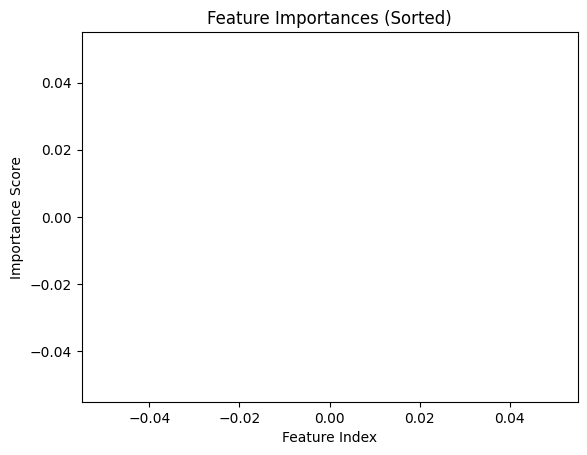

In [ ]:
importance = reg.feature_importances_

feature_importance_pairs = list(zip(feature_names, importance))
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

for i, (feature, score) in enumerate(sorted_feature_importance_pairs):
    print(f'{i+1}. Feature: {feature}, Score: {score}')

sorted_importance = [score for feature, score in sorted_feature_importance_pairs]

plt.bar([x for x in range(len(sorted_importance))], sorted_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importances (Sorted)')
plt.show()

### Neural Network

In [ ]:
import torch
import torch.nn as nn

class NeuralAuctioneer(nn.Module):
    def __init__(self, num_of_items, num_embeddings)
        super().__init__()
        self.item_embeddings = nn.Embedding(num_of_items, num_embeddings)
        self.fc1 = nn.Linear(16 + num_embeddings, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(32)

    def forward(self, x):
        item_embeddings = self.item_embeddings(x[:, 16].long())
        x = torch.cat([x[:, :16], item_embeddings], dim=1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.fc2(x)

In [ ]:
import torch
import torch.nn as nn

class NeuralAuctioneer(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return self.fc4(x)

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = NeuralAuctioneer().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

for epoch in range(100):
    for step, (X_train, y_train) in enumerate(train_dl):
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        output = net(X_train)

        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            rmse = torch.sqrt(loss)
            print(f'Epoch: {epoch}, Loss: {loss.item()} RMSE: {rmse.item()}')

    with torch.no_grad():
        val_losses = []
        for X_test, y_test in test_dl:
            X_test, y_test = X_test.to(device), y_test.to(device)
            output = net(X_test)
            loss = criterion(output, y_test)
            rmse = torch.sqrt(loss)
            val_losses.append(rmse.item())

        print(f'Epoch: {epoch}, RMSE: {np.mean(val_losses)}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 589.6768188476562 RMSE: 24.283262252807617


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([382])) that is different to the input size (torch.Size([382, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([327])) that is different to the input size (torch.Size([327, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, RMSE: 15.08736934264501
Epoch: 1, Loss: 229.25064086914062 RMSE: 15.14102554321289
Epoch: 1, RMSE: 14.751941740512848
Epoch: 2, Loss: 245.23117065429688 RMSE: 15.659858703613281
Epoch: 2, RMSE: 14.755609432856241
Epoch: 3, Loss: 216.3557891845703 RMSE: 14.709037780761719
Epoch: 3, RMSE: 14.665720919768015
Epoch: 4, Loss: 214.18112182617188 RMSE: 14.634927749633789
Epoch: 4, RMSE: 14.613089680671692
Epoch: 5, Loss: 220.2388916015625 RMSE: 14.840447425842285
Epoch: 5, RMSE: 14.702226161956787
Epoch: 6, Loss: 211.97598266601562 RMSE: 14.559394836425781
Epoch: 6, RMSE: 14.606189787387848
Epoch: 7, Loss: 207.4688720703125 RMSE: 14.403779983520508
Epoch: 7, RMSE: 14.60697321097056
Epoch: 8, Loss: 229.81935119628906 RMSE: 15.159793853759766
Epoch: 8, RMSE: 14.718805511792501
Epoch: 9, Loss: 235.49755859375 RMSE: 15.345930099487305
Epoch: 9, RMSE: 14.627331058184305
Epoch: 10, Loss: 191.27633666992188 RMSE: 13.830268859863281
Epoch: 10, RMSE: 14.603594621022543
Epoch: 11, Loss: 191.4

### Full data

In [ ]:
cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error').mean()

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
features = np.array(column_transformer.transformers_[0][1].get_feature_names(categorical_columns).tolist() + numerical_columns)

In [ ]:
sorted_idx = reg.feature_importances_.argsort()

plt.figure(figsize=(8,12))
plt.barh(features[sorted_idx], reg.feature_importances_[sorted_idx])

# Finetuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'randomforestregressor__n_estimators': [3, 10, 30], 'randomforestregressor__max_features': [2, 4, 6, 8]},
    {'randomforestregressor__bootstrap': [False], 'randomforestregressor__n_estimators': [3, 10], 'randomforestregressor__max_features': [2, 3, 4]}
]

reg = RandomForestRegressor()

pipeline = make_pipeline(
    column_transformer,
    reg
)


grid_search = GridSearchCV(pipeline, param_grid, cv=5,scoring='neg_mean_absolute_error',return_train_score=True)

grid_search.fit(X, y)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [ ]:
X.columns

In [ ]:
sorted_idx = grid_search.best_estimator_._final_estimator.feature_importances_.argsort()

plt.figure(figsize=(8,24))
plt.barh(X.columns[sorted_idx], grid_search.best_estimator_._final_estimator.feature_importances_[sorted_idx])

# Save model

In [ ]:
import pickle

filename = 'model.sav'
pickle.dump(reg, open(filename, 'wb'))

# Load model

In [ ]:
import pickle

filename = 'model.sav'
reg = pickle.load(open(filename, 'rb'))

# Data for prediction

Historical data from database

In [ ]:
result, headers = get_data(sql, config)

df_historical = pd.DataFrame.from_records(result, columns=headers)
df_historical = df_historical[df_historical['BuyoutGold'] > 0]
df_historical = df_historical[df_historical['TimeLeft'] == 'VERY_LONG']
df_historical.loc[:,'Sold'] = df_historical['TimesSeen'] <= 12
df_historical['UnitPrice'] = df_historical['BuyoutGold'] / df_historical['Quantity']
df_historical = df_historical[df_historical['Sold'] == True]

df_historical.head()

Item data

In [ ]:
with open("sql/get_items.sql", "r") as f:
    sql_items = f.read()

result, headers = get_data(sql_items, config)

items = pd.DataFrame.from_records(result, columns=headers)
items['ItemId'] = items['Id']
items['SellPrice'] = items['SellPriceGold'] + items['SellPriceSilver'] / 100.0

items.head(3)

Get actual auction data

In [ ]:
auctions = get_auction_data(save=False)

df_actual = pd.DataFrame.from_records(auctions, columns=['Id', 'ItemId', 'BidGold', 'BidSilver', 'BuyoutGold', 'BuyoutSilver', 'Quantity', 'TimeLeft', 'Rand', 'Seed'])
df_actual['BuyoutGold'] = df_actual['BuyoutGold'] + (df_actual['BuyoutSilver'] / 100.0)
df_actual['UnitPrice'] = df_actual['BuyoutGold'] / df_actual['Quantity']
df_actual = df_actual[df_actual['BuyoutGold'] > 0]

df_actual.head()

In [ ]:
historical_price = df_historical.groupby(by=['ItemId'])['UnitPrice'].median().reset_index(name='HistoricalPrice')
median_competitor_price = df_actual.groupby(by=['ItemId'])['UnitPrice'].median().reset_index(name='MedianCompetitorPrice')
lowest_competitor_price = df_actual[df_actual['UnitPrice'] > 0].groupby(by=['ItemId'])['UnitPrice'].min().reset_index(name='LowestCompetitorPrice')

# Model Prediction

In [ ]:
predict = pd.read_csv('predict.csv')
predict.head()

In [ ]:
df_merged = pd.merge(predict, historical_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, median_competitor_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, lowest_competitor_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, items[['ItemId', 'Name', 'Quality', 'ItemClass']], on=['ItemId'], how='left')

df_merged['HistoricalPrice'] = df_merged['HistoricalPrice'].fillna(0)
df_merged['MedianCompetitorPrice'] = df_merged['MedianCompetitorPrice'].fillna(0)
df_merged['LowestCompetitorPrice'] = df_merged['LowestCompetitorPrice'].fillna(0)

df_merged.head(10)

In [ ]:
quantity = 1
predictions = reg.predict(df_merged[['Quantity', 'HistoricalPrice', 'MedianCompetitorPrice', 'LowestCompetitorPrice']]) * quantity

df_merged['RecommendedPrice'] = predictions
df_merged.to_csv('predictions.csv')

# Get best offers

In [ ]:
df_merged = pd.merge(df_actual, historical_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, median_competitor_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, lowest_competitor_price, on=['ItemId'], how='left')
df_merged = pd.merge(df_merged, items[['ItemId', 'Name', 'Quality', 'ItemClass']], on=['ItemId'], how='left')

df_merged['HistoricalPrice'] = df_merged['HistoricalPrice'].fillna(0)
df_merged['MedianCompetitorPrice'] = df_merged['MedianCompetitorPrice'].fillna(0)
df_merged['LowestCompetitorPrice'] = df_merged['LowestCompetitorPrice'].fillna(0)

df_merged.head()

In [ ]:
predictions = reg.predict(df_merged[['Quantity', 'HistoricalPrice', 'MedianCompetitorPrice', 'LowestCompetitorPrice']])

df_predictions = pd.DataFrame(predictions, columns=['RecommendedPrice'])
df_predictions['Id'] = df_merged[['Id']]

df_predictions.head()

In [ ]:
interest_columns = ['Id', 'ItemId', 'Name', 'Quantity', 'HistoricalPrice', 'MedianCompetitorPrice', 'LowestCompetitorPrice', 'UnitPrice', 'BuyoutGold']

df_merged_recommended = pd.merge(df_merged[interest_columns], df_predictions, on=['Id'], how='left')
df_merged_recommended = df_merged_recommended[df_merged_recommended['HistoricalPrice'] > 0]

df_merged_recommended['PriceDifference'] = df_merged_recommended['RecommendedPrice'] - df_merged_recommended['BuyoutGold']
df_merged_recommended['RelativeCompetitorPrice'] = df_merged_recommended['LowestCompetitorPrice'] / df_merged_recommended['MedianCompetitorPrice']
df_merged_recommended['RelativeHistoricalPrice'] = df_merged_recommended['LowestCompetitorPrice'] / df_merged_recommended['HistoricalPrice']

df_merged_recommended[df_merged_recommended['PriceDifference'] >= 1].to_csv('recommended_sales.csv')
df_merged_recommended[df_merged_recommended['PriceDifference'] >= 1].head()

# Get items sold in auction at a price lower than vendor price

In [ ]:
columns = ['Name', 'UnitPrice', 'SellPrice', 'Underpriced']

df_merged = pd.merge(df_actual, items, on=['ItemId'], how='left')
df_merged['Underpriced'] = df_merged['UnitPrice'] < df_merged['SellPrice']
df_merged[columns].head()

In [ ]:
df_merged[df_merged['Underpriced'] == True][columns].to_csv('underpriced.csv')

Eval

In [ ]:
import os
import sys
import sqlite3
import json
import pandas as pd
import pickle

from datetime import datetime
from tqdm import tqdm
from pathlib import Path

In [ ]:
db_path = 'auction.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

query = """
    SELECT
        a.auction_id,
        a.bid / 10000.0 AS bid_in_gold,
        a.buyout / 10000.0 AS buyout_in_gold,
        (a.buyout / 10000.0) / a.quantity AS unit_price,
        a.quantity,
        a.time_left,
        a.item_id,
        i.item_name,
        i.quality,
        i.item_class,
        i.item_subclass,
        i.is_stackable,
        i.purchase_price_gold,
        i.required_level,
        i.item_level,
        i.sell_price_gold,
        MIN(ae.record) AS first_appearance_timestamp,
        strftime('%Y', MIN(ae.record)) AS first_appearance_year,
        strftime('%m', MIN(ae.record)) AS first_appearance_month,
        strftime('%d', MIN(ae.record)) AS first_appearance_day,
        strftime('%H', MIN(ae.record)) AS first_appearance_hour,
        COUNT(*) AS hours_on_sale
    FROM Auctions a
    JOIN ActionEvents ae ON a.auction_id = ae.auction_id
    JOIN Items i ON i.item_id = a.item_id
    GROUP BY a.auction_id
"""

cursor.execute(query)
results = cursor.fetchall()

conn.close()

df = pd.DataFrame(results, columns=[i[0] for i in cursor.description])
df.head(10)

,auction_id,bid_in_gold,buyout_in_gold,unit_price,quantity,time_left,item_id,item_name,quality,item_class,...,purchase_price_gold,required_level,item_level,sell_price_gold,first_appearance_timestamp,first_appearance_year,first_appearance_month,first_appearance_day,first_appearance_hour,hours_on_sale
0,1017748581,1.8999,1.9999,0.666633,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
1,1017748585,1.8999,1.9999,0.666633,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
2,1017748590,1.8999,1.9999,0.666633,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
3,1017748600,1.8999,1.9999,0.666633,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
4,1017748608,0.0150,0.0000,0.000000,2,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
5,1017748611,0.0225,0.0000,0.000000,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
6,1017748613,0.0225,0.0000,0.000000,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
7,1017748622,0.0225,0.0000,0.000000,3,SHORT,15869,Silver Skeleton Key,Uncommon,Consumable,...,0,0,20,0,2024-02-23 00:00:00,2024,02,23,00,1
8,1017748679,5.0065,5.2699,5.269900,1,SHORT,3186,Viking Sword,Uncommon,Weapon,...,2,25,30,0,2024-02-23 00:00:00,2024,02,23,00,1
9,1017748695,9.5000,10.0000,10.000000,1,SHORT,10113,Wanderer's Shoulders,Uncommon,Armor,...,6,52,57,1,2024-02-23 00:00:00,2024,02,23,00,1


In [ ]:
df = add_features(df)

df.head(5)

,auction_id,bid_in_gold,buyout_in_gold,unit_price,quantity,time_left,item_id,item_name,quality,item_class,...,std_competitor_price,competitor_count,lowest_competitor_price,top_competitor_price,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor
0,1017748581,1.8999,1.9999,0.666633,3,2,15869,Silver Skeleton Key,Uncommon,Consumable,...,0.351343,9,0.0,0.666633,0.000050,0.587795,0.000000,0.00000,13.409997,0.000000
1,1017748585,1.8999,1.9999,0.666633,3,2,15869,Silver Skeleton Key,Uncommon,Consumable,...,0.351343,9,0.0,0.666633,0.000050,0.587795,0.000000,0.00000,13.409997,0.000000
2,1017748590,1.8999,1.9999,0.666633,3,2,15869,Silver Skeleton Key,Uncommon,Consumable,...,0.351343,9,0.0,0.666633,0.000050,0.587795,0.000000,0.00000,13.409997,0.000000
3,1017748600,1.8999,1.9999,0.666633,3,2,15869,Silver Skeleton Key,Uncommon,Consumable,...,0.351343,9,0.0,0.666633,0.000050,0.587795,0.000000,0.00000,13.409997,0.000000
4,1017748608,0.0150,0.0000,0.000000,2,2,15869,Silver Skeleton Key,Uncommon,Consumable,...,0.351343,9,0.0,0.666633,-13.409947,-12.822201,-14.508608,-4.84144,0.000000,-13.409997


In [ ]:
df = df[(df['time_left'] != 2)]

X, y = transform_data(df)


df.shape, X.shape, y.shape

Dataframe shape before duplicates (102713, 40)
Dataframe shape after duplicates (37790, 40)


((37790, 40), (37790, 32), (37790,))

In [ ]:
pd.options.display.float_format = '{:.0f}'.format

with open('forest_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [ ]:
df.columns

Index(['auction_id', 'bid_in_gold', 'buyout_in_gold', 'unit_price', 'quantity',
       'time_left', 'item_id', 'item_name', 'quality', 'item_class',
       'item_subclass', 'is_stackable', 'purchase_price_gold',
       'required_level', 'item_level', 'sell_price_gold',
       'first_appearance_timestamp', 'first_appearance_year',
       'first_appearance_month', 'first_appearance_day',
       'first_appearance_hour', 'hours_on_sale', 'median_buyout_price',
       'median_bid_price', 'median_unit_price', 'rank_buyout_price',
       'rank_bid_price', 'rank_unit_price', 'avg_competitor_price',
       'std_competitor_price', 'competitor_count', 'lowest_competitor_price',
       'top_competitor_price', 'relative_price_difference',
       'relative_avg_price_difference', 'relative_buyout_difference',
       'relative_bid_difference', 'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor'],
      dtype='object')

In [ ]:
predictions = reg.predict(X)
df['prediction'] = predictions
df[['item_name', 'item_class', 'unit_price', 'bid_in_gold', 'buyout_in_gold', 'median_buyout_price', 'rank_buyout_price', 'relative_buyout_difference', 'time_left', 'hours_on_sale', 'prediction']].head(20)

,item_name,item_class,unit_price,bid_in_gold,buyout_in_gold,median_buyout_price,rank_buyout_price,relative_buyout_difference,time_left,hours_on_sale,prediction
1333,Glyph of Divinity,Glyph,1.999600,1.8997,1.9996,1.99760,25.0,0.001001,12,3,17.245812
1334,Glyph of Inner Fire,Glyph,1.608700,1.5283,1.6087,1.60780,14.0,0.000560,12,3,19.690887
1335,Glyph of Garrote,Glyph,1.249500,1.1871,1.2495,1.24860,12.5,0.000721,12,3,16.255784
1337,Percussion Shotgun,Weapon,0.000000,2.6686,0.0000,5.47775,1.0,-15.516205,12,3,30.483072
1338,Backbreaker,Weapon,0.000000,7.2275,0.0000,42.50000,1.0,-17.565015,12,3,30.150321
1339,Combustion Dagger,Weapon,0.000000,9.8602,0.0000,8.99980,1.0,-16.012713,12,3,22.720000
1340,Wolfshead Helm,Armor,109.999800,109.9998,109.9998,109.99955,2.0,0.000002,12,3,19.798155
1341,Duskwoven Sandals,Armor,0.000000,1.0624,0.0000,0.00000,1.0,0.000000,12,3,25.722015
1342,Heavy Knothide Armor Kit,Consumable,47.999900,45.5999,47.9999,47.99960,7.0,0.000006,12,3,17.400519
1343,Skoll's Fang,Weapon,1750.564500,1750.0334,1750.5645,895.99980,7.5,0.669753,12,3,18.470000


In [ ]:
y.shape, predictions.shape

((102713,), (102713,))

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, predictions)

print("MAE:", mae)

MAE: 9.438375356677744


In [ ]:
df.to_excel("/content/MAE_9_1.xlsx")

In [ ]:
predictions = reg.predict(X_test)
df_test['prediction'] = predictions

# Error - Correlation analysis

In [ ]:
df_a = dt_test

NameError: name 'dt_test' is not defined

In [ ]:
df_val = pd.read_excel('MAE_5_54.xlsx')
df_test = pd.read_excel('test.xlsx')

df_val['error'] = np.abs(df_val['hours_on_sale'] - df_val['prediction'])
df_test['error'] = np.abs(df_test['hours_on_sale'] - df_test['prediction'])

df_test.head()

,item_name,item_class,unit_price,bid_in_gold,buyout_in_gold,time_left,first_appearance_timestamp,median_buyout_price,median_bid_price,median_unit_price,...,top_competitor_price,relative_price_difference,relative_avg_price_difference,relative_buyout_difference,relative_bid_difference,relative_price_to_lowest_competitor,relative_price_to_top_competitor,hours_on_sale,prediction,error
0,Wool Cloth,Trade Goods,0.0000,1.4161,0.0000,12,2023-11-04 00:00:00,8.5167,8.0990,0.50350,...,0.98676,-0.999998,-0.061477,-1.000000,-0.825151,-0.999997,-0.999999,3,8.174846,5.174846
1,Recipe: Charred Bear Kabobs,Recipe,40.0000,38.0000,40.0000,12,2023-11-04 00:00:00,21.9499,20.8525,21.94990,...,21.99982,0.822332,3.605216,0.822332,0.822323,0.822332,0.818197,3,8.789125,5.789125
2,Green Hills of Stranglethorn - Page 24,Quest,0.4435,0.4214,0.4435,12,2023-11-04 00:00:00,0.4937,0.4691,0.24975,...,29.95950,0.775773,-0.751520,-0.101681,-0.101684,0.795362,-0.985197,3,6.927094,3.927094
3,Ebonweave Gloves,Armor,63.9998,63.9998,63.9998,12,2023-11-04 00:00:00,63.9997,63.9997,63.99970,...,63.99980,0.000002,0.305329,0.000002,0.000002,0.081084,0.000000,2,7.339013,5.339013
4,Khan'aish Girdle,Armor,18.4704,14.7764,18.4704,12,2023-11-04 00:00:00,14.2352,12.1382,14.23520,...,16.77632,0.297516,0.707107,0.297516,0.217347,0.638818,0.100980,3,3.889767,0.889767


In [ ]:
np.abs(np.array(df_test['hours_on_sale'] - df_test['prediction'])).mean()

6.451006053644211

In [ ]:
df_val.columns

Index(['Unnamed: 0', 'auction_id', 'bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id', 'item_name',
       'quality', 'item_class', 'item_subclass', 'is_stackable',
       'purchase_price_gold', 'required_level', 'item_level',
       'sell_price_gold', 'first_appearance_timestamp',
       'first_appearance_year', 'first_appearance_month',
       'first_appearance_day', 'first_appearance_hour', 'hours_on_sale',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor', 'predictions', 'prediction',
       'error'],
      dtype

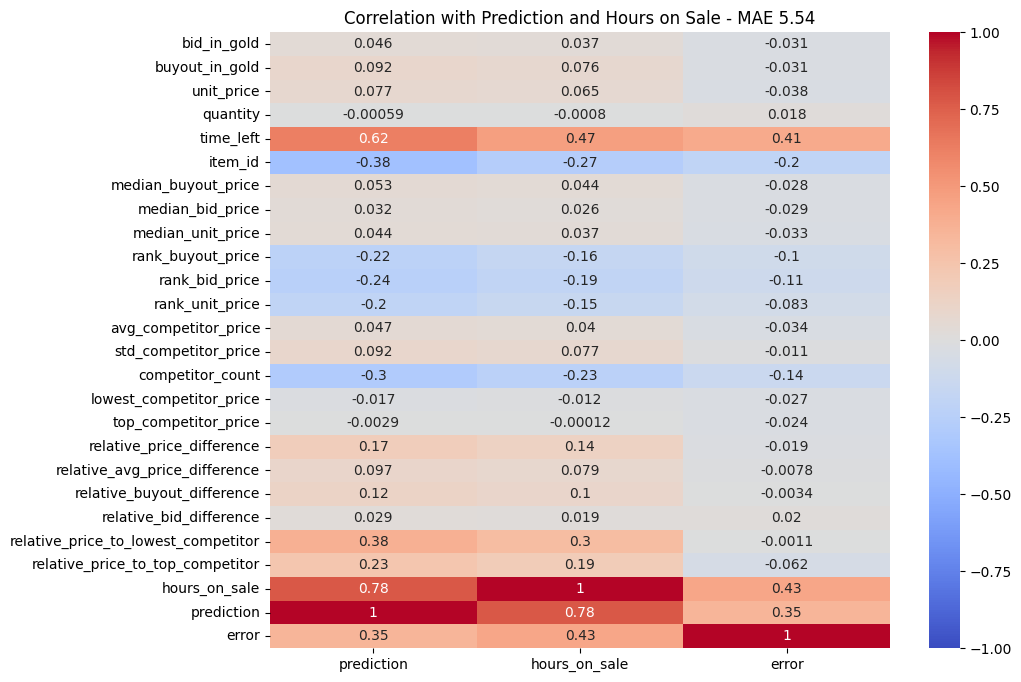

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df_val[['bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id',
       #'first_appearance_year', 'first_appearance_month','first_appearance_day', 'first_appearance_hour',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor','hours_on_sale', 'prediction', 'error']].corr()

# Select only correlations with 'prediction' and 'hours_on_sale'
corr_matrix = corr_matrix[['prediction', 'hours_on_sale', 'error']]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Prediction and Hours on Sale - MAE 5.54')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df_test[['bid_in_gold', 'buyout_in_gold',
       'unit_price', 'quantity', 'time_left', 'item_id',
       'first_appearance_year', 'first_appearance_month','first_appearance_day', 'first_appearance_hour',
       'median_buyout_price', 'median_bid_price', 'median_unit_price',
       'rank_buyout_price', 'rank_bid_price', 'rank_unit_price',
       'avg_competitor_price', 'std_competitor_price', 'competitor_count',
       'lowest_competitor_price', 'top_competitor_price',
       'relative_price_difference', 'relative_avg_price_difference',
       'relative_buyout_difference', 'relative_bid_difference',
       'relative_price_to_lowest_competitor',
       'relative_price_to_top_competitor','hours_on_sale', 'prediction', 'error']].corr()

# Select only correlations with 'prediction' and 'hours_on_sale'
corr_matrix = corr_matrix[['prediction', 'hours_on_sale', 'error']]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Prediction and Hours on Sale - MAE 6.1')
plt.show()

KeyError: "['quantity', 'item_id'] not in index"

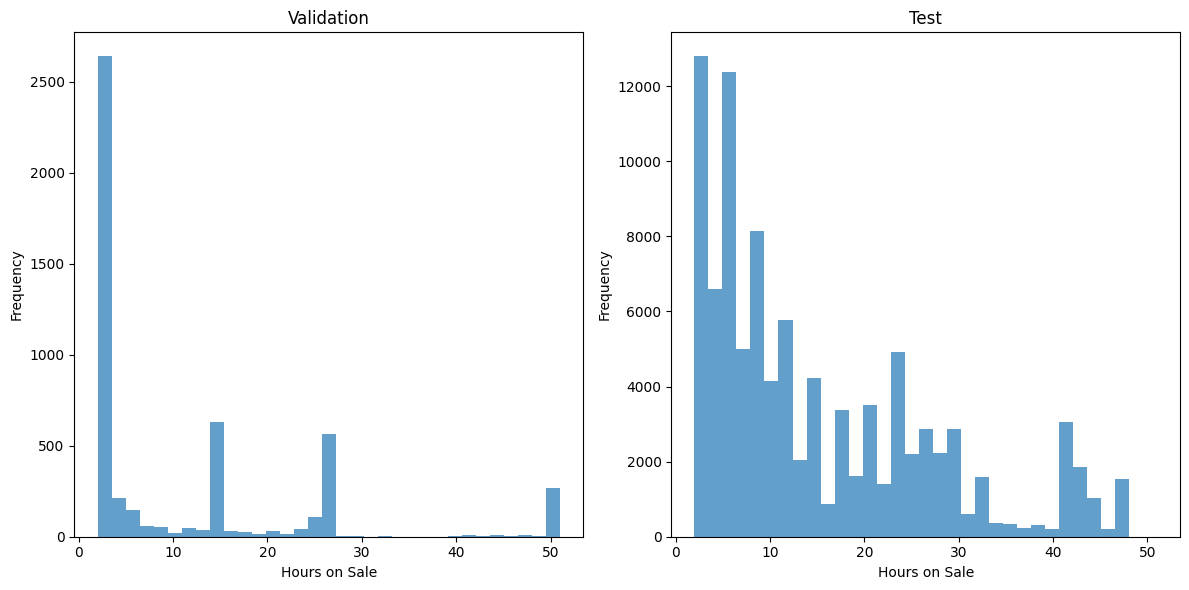

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

bins = np.histogram_bin_edges(df_val['hours_on_sale'], bins='auto')
ax[0].hist(df_val['hours_on_sale'], bins=bins, alpha=0.7, label='Validation')
ax[0].set_xlabel('Hours on Sale')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Validation')

ax[1].hist(df_test['hours_on_sale'], bins=bins, alpha=0.7, label='Test')
ax[1].set_xlabel('Hours on Sale')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Test')

plt.tight_layout()
plt.show()

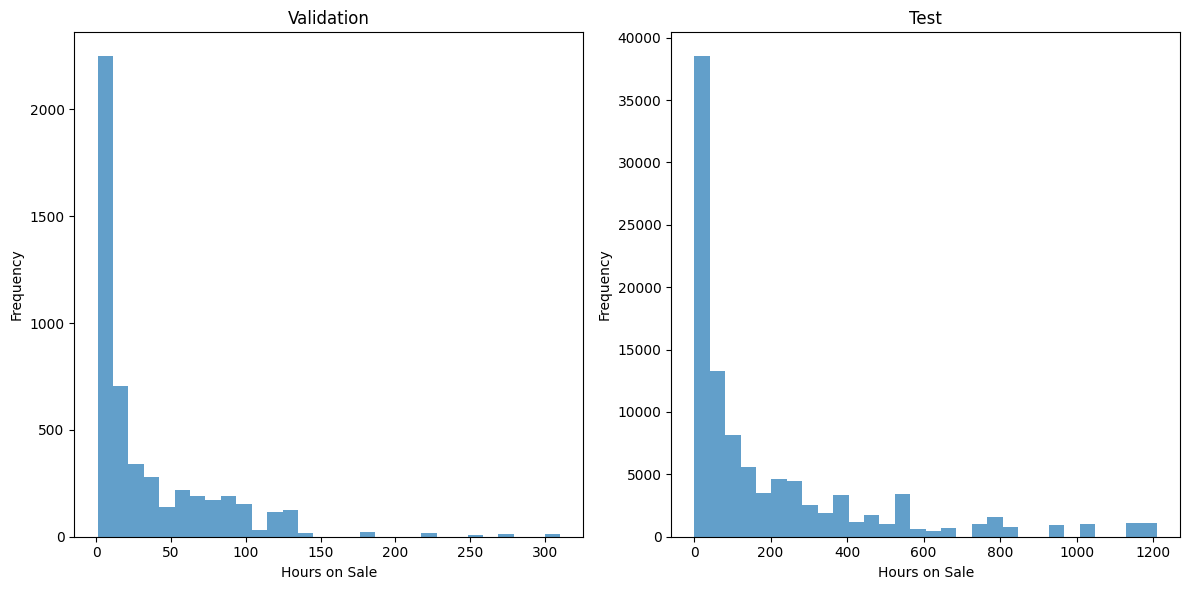

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df_val['competitor_count'], bins=30, alpha=0.7, label='Validation')
ax[0].set_xlabel('Hours on Sale')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Validation')

ax[1].hist(df_test['competitor_count'], bins=30, alpha=0.7, label='Test')
ax[1].set_xlabel('Hours on Sale')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Test')

plt.tight_layout()
plt.show()

   time_left     error
0         24  3.022830
1         48  8.091958
   time_left      error
0         12   2.632007
1         24   2.931505
2         48  10.184960


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

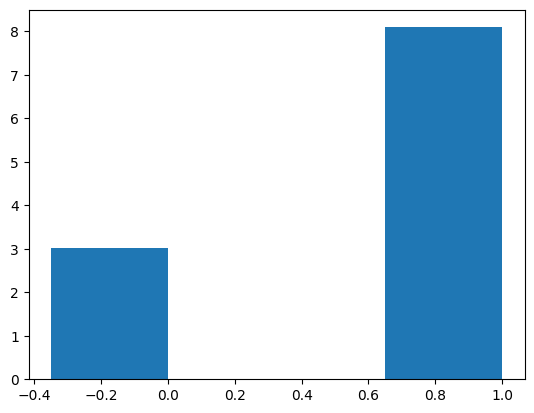

In [ ]:
mean_errors_val = df_val.groupby('time_left')['error'].mean().reset_index()
mean_errors_test = df_test.groupby('time_left')['error'].mean().reset_index()

print(mean_errors_val)
print(mean_errors_test)

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a bar plot with the validation and test bars side by side
bar_width = 0.35
x = np.arange(len(mean_errors_val))
ax.bar(x - bar_width/2, mean_errors_val['error'], bar_width, label='Validation (5.4 MAE)')
ax.bar(x + bar_width/2, mean_errors_test['error'], bar_width, label='Test (9.1 MAE)')

# Set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(mean_errors_val['time_left'])

plt.xlabel('Time Left')
plt.ylabel('Mean Error')
plt.title('Mean Error by Time Left (Validation vs Test)')
plt.legend()
plt.show()